In [25]:
from settings import s, e
import numpy as np
import tensorflow as tf
import tensorflow.keras.backend as K
import pickle

from IPython.display import HTML, clear_output, display, update_display
import matplotlib.pyplot as plt


from simple import Game

from agent_code.tensor_agent.agent import TensorAgent
from agent_code.tensor_agent.hyperparameters import hp
from agent_code.tensor_agent.X import RelativeX2 as game_state_X
from agent_code.tensor_agent.model import FullModel

clear_output()

In [26]:
hp.buffer_size = 30000
hp.target_network_period = 3000
hp.epsilon = 0.
hp.learning_rate=0.001
hp.discount_factor=0.99

In [27]:
import numpy as np
import tensorflow as tf

import time
from copy import copy

from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, ZeroPadding2D, MaxPooling2D, Cropping2D, Concatenate
from tensorflow.keras.models import Sequential, Model

from tensorflow.keras import backend as K

from agent_code.tensor_agent.hyperparameters import hp

from agent_code.tensor_agent.loss import weighted_huber_loss, huber_loss
from agent_code.tensor_agent.layers import NoisyDense, VAMerge


def create_conv_net(shape):
    # Convolutional part of the network
    inputs = Input(shape=shape)
    x = Conv2D(32,1, padding='same', activation='relu')(inputs)
    
    x2 = Cropping2D(14)(inputs)
    x2 = Conv2D(64,3, padding='same', activation='relu')(x2)
    x2 = Flatten()(x2)
    
    x3 = Cropping2D(10)(inputs)
    x3 = Conv2D(64, 3, padding='same', activation='relu')(x3)
    x3 = Conv2D(64, 3, strides=(2,2), padding='same', activation='relu')(x3)
    x3 = Flatten()(x3)
    
    x = Conv2D(64,4, strides=(2,2), padding='same', activation='relu')(x)
    x = Conv2D(64,3, strides=(2,2), padding='same', activation='relu')(x)
    x = MaxPooling2D()(x)
    x = Conv2D(64,3, strides=(1,1), padding='same', activation='relu')(x)
    x = Flatten()(x)

    outputs = Concatenate()([x, x2, x3])

    return inputs, outputs

def create_stream(x, D):
    
    s = NoisyDense(512, activation='relu')(x)
    s = NoisyDense(D, activation=None)(s)
    return s

def create_model(shape, D):
    # Create the convolutional network
    
    inputs, x = create_conv_net(shape=shape)
   
    # Dueling networks:
    # - Split the model into value stream and advantage stream
    v = create_stream(x, 1)
    a = create_stream(x, D)
    # - Merge streams
    outputs = VAMerge()([v, a])
    #outputs = Activation('relu')(outputs)

    model = Model(inputs=inputs, outputs=outputs)
    return model, inputs, outputs

class FullModel:
    def __init__(self, input_shape, D):
        self.input_shape = input_shape
        self.D = D

        #========================
        #  Define Model
        #========================

        # Define online and target models for Double Q-learning
        self.online, _, _ = create_model(input_shape, D)
        self.target, t_in, t_out = create_model(input_shape, D)

        
        #========================
        #  Define Training Update
        #========================
        action_holder = Input(shape=(1,), dtype='int32')  # in j=0,...,D-1
        reward_holder = Input(shape=(1,))
        weight_holder = Input(shape=(1,))
        
        # applies a mask to the outputs so that only the prediction for the chosen action is considered
        responsible_weight = tf.batch_gather(t_out, action_holder)
        
        loss = weighted_huber_loss(reward_holder, responsible_weight, weight_holder)
        tf.summary.scalar('loss', loss)
        tf.summary.scalar('reward', tf.reduce_mean(reward_holder))

        optimizer = tf.train.AdamOptimizer(hp.learning_rate, epsilon=hp.adam_epsilon)
        update = optimizer.minimize(loss)

        merged_summary = tf.summary.merge_all()

        self.summary = merged_summary
        self.train_writer = tf.summary.FileWriter(f'tf-board/train/{time.time()}',
                                      K.get_session().graph)
        
        self.errors=tf.abs(reward_holder-responsible_weight)
        self.input_ph = t_in
        self.t_out = t_out
        self.action_ph = action_holder
        self.reward_ph = reward_holder
        self.update_op = update
        self.weights = weight_holder

        self.steps = 0


    def update(self, inputs, actions, rewards, per_weights):
        sess = K.get_session()
        _, errors, summary = sess.run([self.update_op, self.errors, self.summary], feed_dict={
            self.input_ph: inputs,
            self.action_ph:actions,
            self.reward_ph:rewards,
            self.weights:per_weights
        })
        self.train_writer.add_summary(summary, self.steps)
        self.steps += 1
        return errors

    def update_online(self):
        self.online.set_weights(self.target.get_weights())

    def save(self, file='my_model.h5'):
        self.target.save(file)

    def load_weights(self, file='my_model.h5'):
        self.online.load_weights(file)
        self.target.load_weights(file)

    def clone(self, share_online=True):
        clone = copy(self)
        if not share_online:
            clone.online, _, _ = create_model(input_shape, D)

        return clone


In [39]:
choices = ['RIGHT', 'LEFT', 'UP', 'DOWN', 'BOMB', 'WAIT']
D = len(choices)

K.clear_session()
model = FullModel(game_state_X.shape, D)

agents = {
    'tensor_agent': TensorAgent(game_state_X.shape, D, weights='tensor_agent-model.h5', model=model) # alt: weights='tensor_agent-model.h5'
}
train = {a: False for a in agents}
clear_output()

In [40]:

def get_valid_actions(x, y, game):
    # choices = ['RIGHT', 'LEFT', 'UP', 'DOWN', 'BOMB', 'WAIT']
    valid = np.ones((6))
    if not game.tile_is_free(x, y-1):
        valid[2] = 0 # UP invalid
    if not game.tile_is_free(x, y+1):
        valid[3] = 0 # DOWN invalid
    if not game.tile_is_free(x-1, y):
        valid[1] = 0 # LEFT invalid
    if not game.tile_is_free(x+1, y):
        valid[0] = 0 # RIGHT invalid

    valid[4] = 0
    valid[5] = 0
    return valid

In [ ]:
d = display(f'Starting...', display_id='progress')

n_steps = 2000000
game = None

train['tensor_agent'] = True
moving_reward = 0

for step in range(n_steps):
    if game is None:
        game = Game(*Game.create_arena(agents.keys()))

    actions = {}
    Xs = {}
    for agent in game.agents:
        x, y, name, _, _ = agent
        
        game_state = game.get_game_state(agent)
        Xs[name] = game_state_X.get(game_state)
        valid_actions = get_valid_actions(x, y, game)
        actions[name] = agents[name].act(Xs[name], train=train[name], valid_actions=valid_actions)
    
    actions_as_string = {n: choices[actions[name]] for n in actions.keys()}
    rewards = game.step(actions_as_string)
    moving_reward = 0.99 * moving_reward + rewards['tensor_agent']
    
    for _, _, name, _, _ in game.agents:
        if train[name]:
            agents[name].reward_update([Xs[name], actions[name], rewards[name]-0.1])
    
    if game.terminated:
        for name, a in agents.items():
            a.end_of_episode(save='tensor_agent-model.h5') # alt: save=None
        
        d.update(f'Step: {step+1}/{n_steps} Trained: {model.steps} Moving Reward: {moving_reward}')
        
        game = None

d.update(f'Complete')

In [ ]:
moving_reward

In [ ]:
d = display(f'Starting...', display_id='progress')

n_steps = 1000
game = None

train['tensor_agent'] = False
moving_reward = 0

imgs = []

for step in range(n_steps):
    if game is None:
        game = Game(*Game.create_arena(agents.keys()))

    actions = {}
    Xs = {}
    for agent in game.agents:
        x, y, name, _, _ = agent
        
        game_state = game.get_game_state(agent)
        img = np.zeros((17, 17, 3))
        img[:,:,0] = game_state['arena'] == -1
        coins = game_state['coins']
        for i in range(len(coins)):
            img[coins[i][0], coins[i][1], 1] = 1
        img[x,y,2] = 1
        imgs.append(img)
        
        Xs[name] = game_state_X.get(game_state)
        valid_actions = get_valid_actions(x, y, game)
        actions[name] = agents[name].act(Xs[name], train=train[name], valid_actions=valid_actions)
    
    actions_as_string = {n: choices[actions[name]] for n in actions.keys()}
    print(actions_as_string)
    rewards = game.step(actions_as_string)
    moving_reward = moving_reward + rewards['tensor_agent']
    
    if game.terminated:
        for name, a in agents.items():
            a.end_of_episode(save='tensor_agent-model.h5') # alt: save=None
        
        d.update(f'Step: {step+1}/{n_steps} Trained: {model.steps} Reward: {moving_reward}')
        
        break



In [19]:

def animation(imgs, r, c, steps, interval=50):
    import matplotlib.animation
    
    fig = plt.gcf()
    plt.axis('off')

    def animate(t):
        plt.imshow(imgs[t])

    ani = matplotlib.animation.FuncAnimation(fig, animate, frames=steps, interval=interval)
    return ani

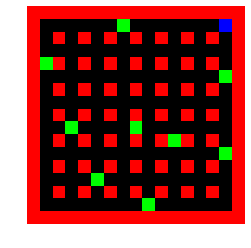

In [22]:
r,c,steps = 1,2,len(imgs)  # number of rows, columns and steps to walk in latent space
anim = animation(imgs,r,c,steps, interval=300)
HTML(anim.to_jshtml())

In [24]:
from PIL import Image
for i in range(len(imgs)):
    Image.fromarray(np.uint8(imgs[i]*255)).resize((17*10,17*10)).save('anim/{:0>2d}.png'.format(i))

In [ ]:
! convert anim/*.png movie.gif